In [ ]:
!pip install -q datasets transformers evaluate librosa soundfile torch torchaudio jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torchaudio
from datasets import load_dataset, Audio
from transformers import (
    WhisperFeatureExtractor,
    WhisperTokenizer,
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
import evaluate
from dataclasses import dataclass
from datasets import load_dataset, Audio, Dataset, DatasetDict
from typing import Any, Dict, List, Union, Optional, Tuple
from tqdm import tqdm
import librosa
import librosa.display
import random
from IPython.display import Audio, display
import gc

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Helper function to clean memory
def clean_memory():
    """Clean up memory to avoid OOM errors"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Check apakah GPU tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create output directories
os.makedirs("audio_augmentations", exist_ok=True)
os.makedirs("model_outputs", exist_ok=True)

# Pilih bahasa untuk fine-tuning (Inggris)
languages = ["en-US"]

Using device: cuda


In [ ]:
# 1. LOAD DATASET DARI HUGGING FACE
print(f"Loading dataset untuk bahasa: {languages}")
datasets_by_lang = {}

# Download datasets for each language
for lang in languages:
    print(f"Downloading dataset untuk {lang}...")
    datasets_by_lang[lang] = load_dataset("PolyAI/minds14", lang, trust_remote_code=True)
    print(f"Dataset {lang} loaded: {len(datasets_by_lang[lang]['train'])} samples")

# Membuat direktori untuk menyimpan visualisasi
os.makedirs("audio_visualizations", exist_ok=True)

Loading dataset untuk bahasa: ['en-US']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

minds14.py:   0%|          | 0.00/5.83k [00:00<?, ?B/s]

MInDS-14.zip:   0%|          | 0.00/471M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset en-US loaded: 563 samples


In [ ]:
# 2. ANALISIS STATISTIK DASAR

# Fungsi untuk mengekstrak statistik dari audio
def extract_audio_stats(audio):
    """
    Ekstrak statistik dasar dari audio
    """
    array = audio["array"]
    sr = audio["sampling_rate"]

    # Durasi dalam detik
    duration = len(array) / sr

    # RMS energy
    rms = np.sqrt(np.mean(array**2))

    # Zero crossing rate
    zero_crossings = librosa.zero_crossings(array, pad=False)
    zcr = sum(zero_crossings) / len(array)

    return {
        "duration": duration,
        "rms_energy": rms,
        "zero_crossing_rate": zcr,
        "sampling_rate": sr
    }

# Kumpulkan statistik untuk setiap bahasa
all_stats = {lang: [] for lang in languages}
intent_counts = {lang: {} for lang in languages}

for lang, dataset in datasets_by_lang.items():
    print(f"Menganalisis statistik untuk {lang}...")

    # Analisis intent distribution
    for sample in dataset["train"]:
        intent = sample["intent_class"]
        if intent not in intent_counts[lang]:
            intent_counts[lang][intent] = 0
        intent_counts[lang][intent] += 1

    # Analisis sampel audio
    # Hanya ambil 100 sampel acak untuk mempercepat proses
    indices = random.sample(range(len(dataset["train"])), min(100, len(dataset["train"])))

    for idx in tqdm(indices, desc=f"Processing {lang} samples"):
        sample = dataset["train"][idx]
        stats = extract_audio_stats(sample["audio"])
        all_stats[lang].append(stats)

Menganalisis statistik untuk en-US...


Processing en-US samples: 100%|██████████| 100/100 [00:01<00:00, 59.82it/s]


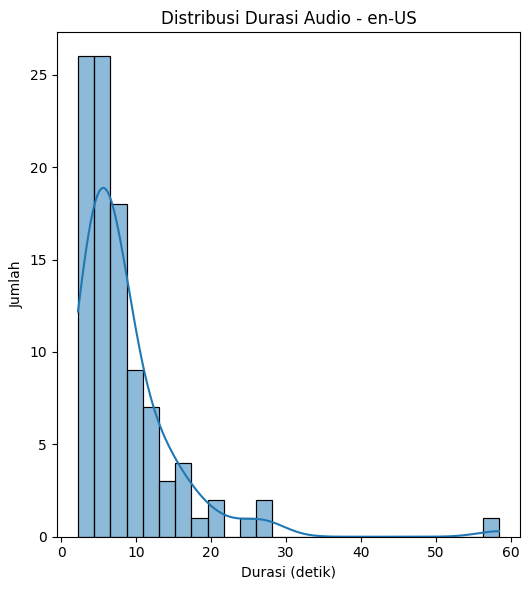

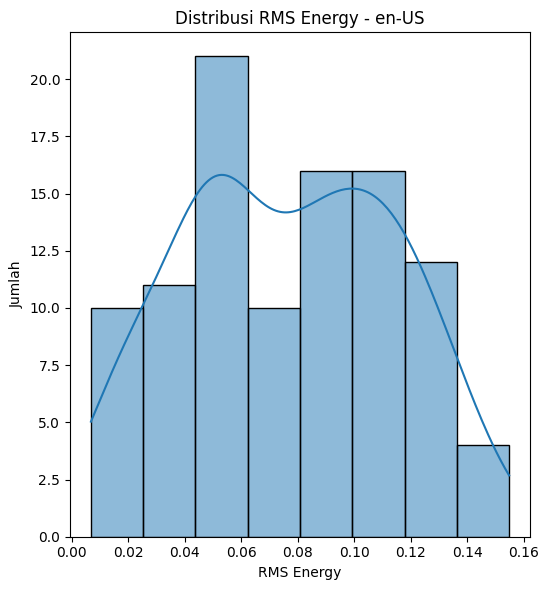

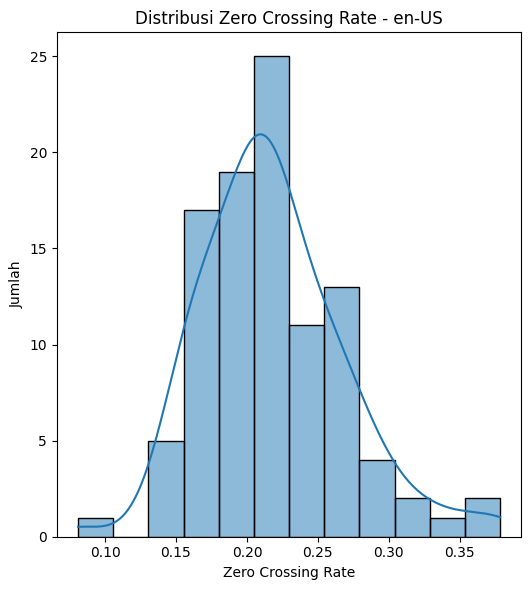

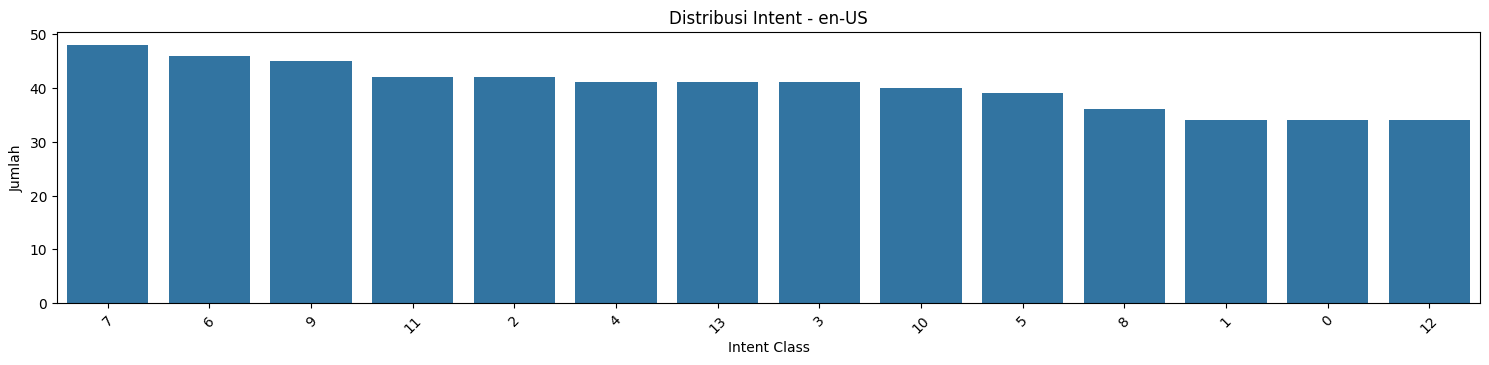

In [ ]:
# 3. VISUALISASI HASIL STATISTIK

# 3.1 Visualisasi distribusi durasi audio
plt.figure(figsize=(15, 6))
for i, lang in enumerate(languages):
    durations = [stat["duration"] for stat in all_stats[lang]]
    plt.subplot(1, 3, i+1)
    sns.histplot(durations, kde=True)
    plt.title(f"Distribusi Durasi Audio - {lang}")
    plt.xlabel("Durasi (detik)")
    plt.ylabel("Jumlah")
plt.tight_layout()
plt.savefig("audio_visualizations/duration_distribution.png")
plt.show()

# 3.2 Visualisasi distribusi RMS energy
plt.figure(figsize=(15, 6))
for i, lang in enumerate(languages):
    rms_values = [stat["rms_energy"] for stat in all_stats[lang]]
    plt.subplot(1, 3, i+1)
    sns.histplot(rms_values, kde=True)
    plt.title(f"Distribusi RMS Energy - {lang}")
    plt.xlabel("RMS Energy")
    plt.ylabel("Jumlah")
plt.tight_layout()
plt.savefig("audio_visualizations/rms_distribution.png")
plt.show()

# 3.3 Visualisasi distribusi zero crossing rate
plt.figure(figsize=(15, 6))
for i, lang in enumerate(languages):
    zcr_values = [stat["zero_crossing_rate"] for stat in all_stats[lang]]
    plt.subplot(1, 3, i+1)
    sns.histplot(zcr_values, kde=True)
    plt.title(f"Distribusi Zero Crossing Rate - {lang}")
    plt.xlabel("Zero Crossing Rate")
    plt.ylabel("Jumlah")
plt.tight_layout()
plt.savefig("audio_visualizations/zcr_distribution.png")
plt.show()

# 3.4 Visualisasi distribusi intent
plt.figure(figsize=(15, 10))
for i, lang in enumerate(languages):
    plt.subplot(3, 1, i+1)
    intents = intent_counts[lang].keys()
    counts = intent_counts[lang].values()

    # Sort untuk visualisasi yang lebih baik
    sorted_items = sorted(intent_counts[lang].items(), key=lambda x: x[1], reverse=True)
    intents = [str(item[0]) for item in sorted_items]
    counts = [item[1] for item in sorted_items]

    sns.barplot(x=intents, y=counts)
    plt.title(f"Distribusi Intent - {lang}")
    plt.xlabel("Intent Class")
    plt.ylabel("Jumlah")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("audio_visualizations/intent_distribution.png")
plt.show()

In [ ]:
# 4. VISUALISASI WAVEPLOT DAN SPEKTROGRAM

# Pilih 3 sampel acak dari setiap bahasa untuk visualisasi
num_samples = 3
viz_samples = {}

for lang in languages:
    indices = random.sample(range(len(datasets_by_lang[lang]["train"])), num_samples)
    viz_samples[lang] = [datasets_by_lang[lang]["train"][idx] for idx in indices]

# Visualisasi waveplot dan spektrogram
for lang in languages:
    print(f"\nVisualisasi untuk {lang}:")

    for i, sample in enumerate(viz_samples[lang]):
        audio = sample["audio"]
        sr = audio["sampling_rate"]
        array = audio["array"]
        transcription = sample["transcription"]

        # Plot
        plt.figure(figsize=(14, 6))

        # Waveplot
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(array, sr=sr)
        plt.title(f"{lang} - Sample {i+1} - Waveplot")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # Spektrogram
        plt.subplot(2, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(array)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Spektrogram (dB)")

        # Save the figure
        plt.tight_layout()
        plt.savefig(f"audio_visualizations/{lang}_sample_{i+1}.png")
        plt.show()

        # Display audio player dan transcription
        print(f"Transcription: {transcription}")
        display(Audio(array, rate=sr))
        print("-" * 50)

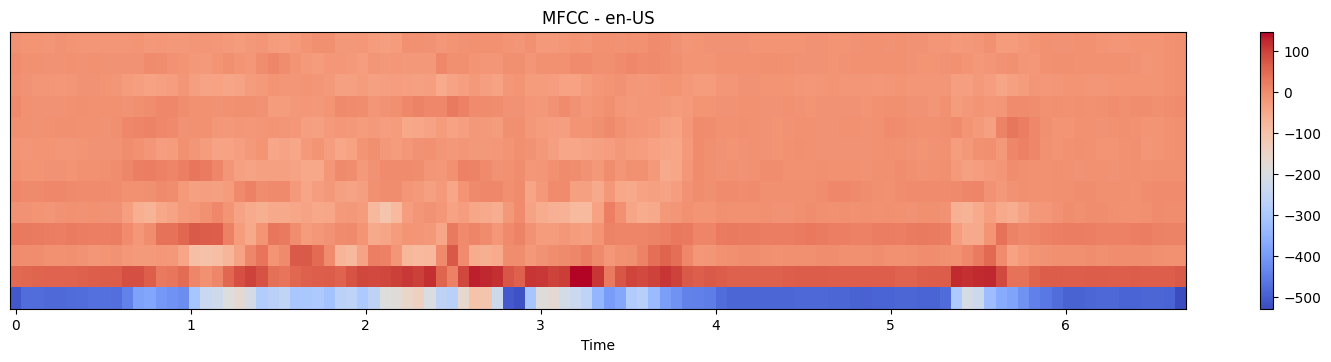

In [ ]:
# 5. FEATURE EXTRACTION DAN VISUALISASI MFCC

# Ekstrak dan visualisasikan MFCC untuk 1 sampel dari setiap bahasa
plt.figure(figsize=(15, 10))
for i, lang in enumerate(languages):
    sample = viz_samples[lang][0]  # Ambil sampel pertama
    array = sample["audio"]["array"]
    sr = sample["audio"]["sampling_rate"]

    # Ekstrak MFCC
    mfccs = librosa.feature.mfcc(y=array, sr=sr, n_mfcc=13)

    # Plot
    plt.subplot(3, 1, i+1)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC - {lang}')
    plt.tight_layout()

plt.savefig("audio_visualizations/mfcc_comparison.png")
plt.show()

In [ ]:
# 6. STATISTIK DASAR DALAM BENTUK TABEL

stats_summary = {}
for lang in languages:
    durations = [stat["duration"] for stat in all_stats[lang]]
    rms_values = [stat["rms_energy"] for stat in all_stats[lang]]
    zcr_values = [stat["zero_crossing_rate"] for stat in all_stats[lang]]

    stats_summary[lang] = {
        "avg_duration": np.mean(durations),
        "min_duration": np.min(durations),
        "max_duration": np.max(durations),
        "std_duration": np.std(durations),
        "avg_rms": np.mean(rms_values),
        "min_rms": np.min(rms_values),
        "max_rms": np.max(rms_values),
        "avg_zcr": np.mean(zcr_values),
        "min_zcr": np.min(zcr_values),
        "max_zcr": np.max(zcr_values),
        "num_samples": len(datasets_by_lang[lang]["train"]),
        "num_intents": len(intent_counts[lang])
    }

# Buat DataFrame untuk tampilan yang lebih baik
stats_df = pd.DataFrame(stats_summary).T
print("\nRingkasan Statistik Dataset:")
print(stats_df)

# Simpan statistik ke CSV
stats_df.to_csv("audio_visualizations/dataset_statistics.csv")
print("\nStatistik disimpan ke audio_visualizations/dataset_statistics.csv")


Ringkasan Statistik Dataset:
       avg_duration  min_duration  max_duration  std_duration   avg_rms  \
en-US      8.518689      2.218625     58.453375      7.289594  0.076722   

        min_rms  max_rms   avg_zcr   min_zcr   max_zcr  num_samples  \
en-US  0.006862  0.15484  0.217908  0.080983  0.378383        563.0   

       num_intents  
en-US         14.0  

Statistik disimpan ke audio_visualizations/dataset_statistics.csv


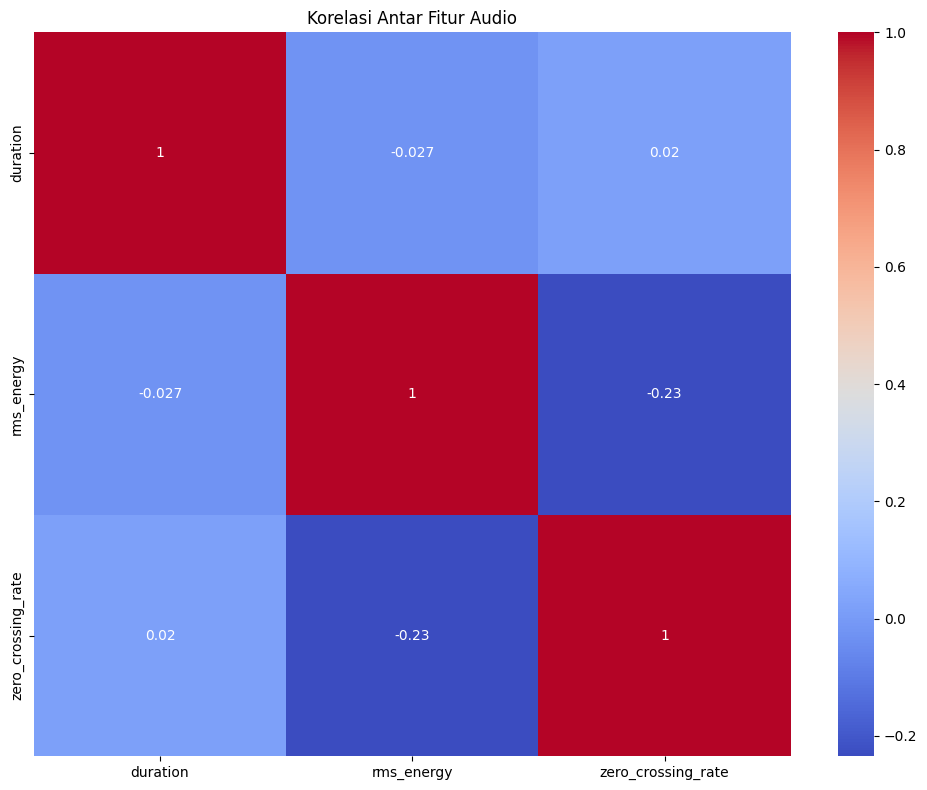


Analisis dan visualisasi selesai! Semua hasil disimpan di folder 'audio_visualizations'


In [ ]:
# 7. KORELASI ANTAR FITUR AUDIO

# Buat DataFrame yang berisi semua statistik
dfs = []
for lang in languages:
    df = pd.DataFrame(all_stats[lang])
    df['language'] = lang
    dfs.append(df)

combined_stats = pd.concat(dfs, ignore_index=True)

# Plot correlation matrix
plt.figure(figsize=(10, 8))
corr = combined_stats[['duration', 'rms_energy', 'zero_crossing_rate']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur Audio')
plt.tight_layout()
plt.savefig("audio_visualizations/feature_correlation.png")
plt.show()

print("\nAnalisis dan visualisasi selesai! Semua hasil disimpan di folder 'audio_visualizations'")

In [ ]:
# 2. DATA AUGMENTATION FUNCTIONS

def time_stretch(waveform, rate=None):
    """
    Apply time stretching to the waveform.
    Args:
        waveform: The input waveform
        rate: The stretching rate. If None, a random rate between 0.8 and 1.2 is used.
    """
    if rate is None:
        # Random time stretch rate between 0.8 and 1.2
        rate = np.random.uniform(0.8, 1.2)

    return librosa.effects.time_stretch(waveform, rate=rate)

def pitch_shift(waveform, sampling_rate, n_steps=None):
    """
    Apply pitch shifting to the waveform.
    Args:
        waveform: The input waveform
        sampling_rate: Sampling rate of the waveform
        n_steps: Number of semitones to shift. If None, a random value between -2 and 2 is used.
    """
    if n_steps is None:
        # Random pitch shift between -2 and 2 semitones
        n_steps = np.random.uniform(-2, 2)

    return librosa.effects.pitch_shift(waveform, sr=sampling_rate, n_steps=n_steps)

def add_noise(waveform, noise_level=None):
    """
    Add Gaussian noise to the waveform.
    Args:
        waveform: The input waveform
        noise_level: The noise level relative to RMS of the waveform.
                     If None, a random level between 0.001 and 0.01 is used.
    """
    if noise_level is None:
        # Random noise level between 0.001 and 0.01
        noise_level = np.random.uniform(0.001, 0.01)

    noise = np.random.normal(0, noise_level, len(waveform))
    return waveform + noise

def adjust_volume(waveform, gain_db=None):
    """
    Adjust the volume of the waveform.
    Args:
        waveform: The input waveform
        gain_db: Gain in dB. If None, a random value between -6 and 6 is used.
    """
    if gain_db is None:
        # Random gain between -6 and 6 dB
        gain_db = np.random.uniform(-6, 6)

    gain_factor = 10 ** (gain_db / 20)
    return waveform * gain_factor

def augment_waveform(waveform, sr, augmentation_methods=None):
    """
    Apply a sequence of augmentation methods to the waveform.
    Args:
        waveform: The input waveform
        sr: Sampling rate of the waveform
        augmentation_methods: List of augmentation methods to apply.
                             If None, a random subset of methods is chosen.
    """
    all_methods = ["time_stretch", "pitch_shift", "add_noise", "adjust_volume"]

    if augmentation_methods is None:
        # Choose a random number of augmentation methods (1-3)
        num_methods = random.randint(1, 3)
        augmentation_methods = random.sample(all_methods, num_methods)

    augmented = waveform.copy()

    for method in augmentation_methods:
        if method == "time_stretch":
            augmented = time_stretch(augmented)
        elif method == "pitch_shift":
            augmented = pitch_shift(augmented, sr)
        elif method == "add_noise":
            augmented = add_noise(augmented)
        elif method == "adjust_volume":
            augmented = adjust_volume(augmented)

    return augmented

In [ ]:
# 3. VISUALIZE SOME AUGMENTED SAMPLES FOR VERIFICATION
def visualize_augmentations(original_dataset, num_samples=3):
    """
    Visualize original and augmented versions of samples
    """
    indices = random.sample(range(len(original_dataset)), num_samples)

    for idx in indices:
        sample = original_dataset[idx]

        # Original waveform
        orig_waveform = sample["audio"]["array"]
        sr = sample["audio"]["sampling_rate"]

        # Create different augmentations
        aug1 = time_stretch(orig_waveform.copy())
        aug2 = pitch_shift(orig_waveform.copy(), sr)
        aug3 = add_noise(orig_waveform.copy())

        # Visualize
        plt.figure(figsize=(15, 8))

        plt.subplot(4, 1, 1)
        librosa.display.waveshow(orig_waveform, sr=sr)
        plt.title(f"Original - '{sample['transcription']}'")

        plt.subplot(4, 1, 2)
        librosa.display.waveshow(aug1, sr=sr)
        plt.title("Time Stretched")

        plt.subplot(4, 1, 3)
        librosa.display.waveshow(aug2, sr=sr)
        plt.title("Pitch Shifted")

        plt.subplot(4, 1, 4)
        librosa.display.waveshow(aug3, sr=sr)
        plt.title("Noise Added")

        plt.tight_layout()
        plt.savefig(f"audio_augmentations/sample_{idx}_augmentations.png")
        plt.close()

        # Save audio samples for listening
        torchaudio.save(f"audio_augmentations/sample_{idx}_original.wav",
                      torch.tensor(orig_waveform).unsqueeze(0),
                      sr)
        torchaudio.save(f"audio_augmentations/sample_{idx}_time_stretched.wav",
                      torch.tensor(aug1).unsqueeze(0),
                      sr)
        torchaudio.save(f"audio_augmentations/sample_{idx}_pitch_shifted.wav",
                      torch.tensor(aug2).unsqueeze(0),
                      sr)
        torchaudio.save(f"audio_augmentations/sample_{idx}_noise_added.wav",
                      torch.tensor(aug3).unsqueeze(0),
                      sr)

# Get dataset from loaded datasets_by_lang
dataset = datasets_by_lang["en-US"]

# Visualize some augmentations
print("\nVisualizing some augmented samples...")
visualize_augmentations(dataset["train"], num_samples=3)


Visualizing some augmented samples...


In [ ]:
# 4. PREPARE DATASET FOR TRAINING

# Split original data into train and test
if "test" not in dataset:
    # Create a train-test split
    train_test_split = dataset["train"].train_test_split(test_size=0.2, seed=seed)
    dataset = DatasetDict({
        "train": train_test_split["train"],
        "test": train_test_split["test"]
    })

print(f"Train set: {len(dataset['train'])} samples")
print(f"Test set: {len(dataset['test'])} samples")

Train set: 450 samples
Test set: 113 samples


In [ ]:
# 5. AUGMENT TRAINING DATA BASED ON TRANSCRIPTION LENGTH
def augment_training_data(dataset, min_samples_per_length=40):
    """
    Augment training data to ensure we have enough samples across different utterance lengths
    """
    # Group samples by transcription length (in ranges)
    length_bins = {}
    for i, sample in enumerate(dataset):
        length = len(sample["transcription"].split())
        bin_key = length // 5  # Group in bins of 5 words

        if bin_key not in length_bins:
            length_bins[bin_key] = []

        length_bins[bin_key].append(i)

    # Find bins that need augmentation
    augmentation_needed = {}
    for bin_key, indices in length_bins.items():
        if len(indices) < min_samples_per_length:
            augmentation_needed[bin_key] = min_samples_per_length - len(indices)

    print(f"Length distribution before augmentation:")
    for bin_key, indices in sorted(length_bins.items()):
        word_range = f"{bin_key*5}-{(bin_key+1)*5-1}"
        print(f"{word_range} words: {len(indices)} samples")

    print(f"\nAugmenting the following length bins:")
    for bin_key, count in sorted(augmentation_needed.items()):
        word_range = f"{bin_key*5}-{(bin_key+1)*5-1}"
        print(f"{word_range} words: need {count} more samples")

    # Augment underrepresented length bins
    augmented_samples = []

    for bin_key, count_needed in augmentation_needed.items():
        # If bin is empty, skip (we can't augment what doesn't exist)
        if bin_key not in length_bins or len(length_bins[bin_key]) == 0:
            continue

        # Choose samples to augment from this bin
        bin_indices = length_bins[bin_key]

        for _ in range(count_needed):
            # Randomly select a sample from this bin
            idx = random.choice(bin_indices)
            sample = dataset[idx]

            # Augment the audio
            waveform = sample["audio"]["array"]
            sr = sample["audio"]["sampling_rate"]

            # Choose random augmentation strategy
            augmented_waveform = augment_waveform(waveform, sr)

            # Create new sample
            augmented_sample = sample.copy()
            augmented_sample["audio"] = {
                "array": augmented_waveform,
                "sampling_rate": sr
            }

            augmented_samples.append(augmented_sample)

    print(f"Created {len(augmented_samples)} augmented samples")

    # Combine original and augmented samples
    combined_dataset = Dataset.from_dict({
        key: [item for item in dataset[key]] + [item.get(key) for item in augmented_samples]
        for key in dataset[0].keys()
    })

    return combined_dataset

# Augment the training dataset
print("\nAugmenting the training dataset...")
augmented_train = augment_training_data(dataset["train"])

print(f"Original train size: {len(dataset['train'])}, Augmented train size: {len(augmented_train)}")

# Prepare the final datasets
final_dataset = DatasetDict({
    "train": augmented_train,
    "test": dataset["test"]
})


Augmenting the training dataset...
Length distribution before augmentation:
0-4 words: 19 samples
5-9 words: 175 samples
10-14 words: 96 samples
15-19 words: 51 samples
20-24 words: 36 samples
25-29 words: 23 samples
30-34 words: 20 samples
35-39 words: 18 samples
40-44 words: 3 samples
45-49 words: 4 samples
50-54 words: 3 samples
65-69 words: 2 samples

Augmenting the following length bins:
0-4 words: need 21 more samples
20-24 words: need 4 more samples
25-29 words: need 17 more samples
30-34 words: need 20 more samples
35-39 words: need 22 more samples
40-44 words: need 37 more samples
45-49 words: need 36 more samples
50-54 words: need 37 more samples
65-69 words: need 38 more samples
Created 232 augmented samples
Original train size: 450, Augmented train size: 682


In [ ]:
# 6. LOAD WHISPER MODEL AND PROCESSOR
model_name = "openai/whisper-tiny"
print(f"\nLoading model: {model_name}")

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name)
tokenizer = WhisperTokenizer.from_pretrained(model_name, language="en", task="transcribe")
processor = WhisperProcessor.from_pretrained(model_name, language="en", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(model_name)

# Print model's required sampling rate
print(f"Model's sampling rate: {feature_extractor.sampling_rate} Hz")


Loading model: openai/whisper-tiny


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

Model's sampling rate: 16000 Hz


In [ ]:
# 7. PREPARE DATASET FOR MODEL
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Extract features and targets
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        labels = [{"input_ids": feature["labels"]} for feature in features]

        # Pad inputs
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # Pad labels
        labels_batch = self.processor.tokenizer.pad(labels, return_tensors="pt")

        # Replace padding with -100 for loss calculation
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # Add labels to batch
        batch["labels"] = labels

        return batch

def prepare_dataset(examples):
    # Process audio
    input_features = []

    for audio in examples["audio"]:
        # Get audio array and sampling rate
        audio_array = audio["array"]
        sampling_rate = audio["sampling_rate"]

        # Ensure audio_array is a numpy array
        if not isinstance(audio_array, np.ndarray):
            audio_array = np.array(audio_array)

        # Trim silence to reduce size (helps with memory usage)
        audio_array, _ = librosa.effects.trim(audio_array, top_db=20)

        # Resample if necessary
        if sampling_rate != feature_extractor.sampling_rate:
            audio_array = librosa.resample(
                y=audio_array,
                orig_sr=sampling_rate,
                target_sr=feature_extractor.sampling_rate
            )

        # Extract features WITHOUT truncation - this is important for Whisper
        input_feature = feature_extractor(
            audio_array,
            sampling_rate=feature_extractor.sampling_rate,
            return_tensors="pt"
        ).input_features[0]

        input_features.append(input_feature)

    # Tokenize transcriptions
    transcriptions = examples["transcription"]
    labels = tokenizer(transcriptions).input_ids

    return {
        "input_features": input_features,
        "labels": labels
    }

# Process datasets in batches to avoid memory issues
def process_dataset_in_batches(dataset, batch_size=32):
    """Process dataset in smaller batches to avoid memory issues"""
    processed_batches = []

    for i in range(0, len(dataset), batch_size):
        end_idx = min(i + batch_size, len(dataset))
        print(f"Processing batch {i} to {end_idx}...")

        # Process batch
        batch = dataset.select(range(i, end_idx))
        processed_batch = batch.map(
            prepare_dataset,
            batched=True,
            batch_size=8,
            remove_columns=dataset.column_names
        )

        processed_batches.append(processed_batch)

        # Clean memory
        clean_memory()

    # Combine all processed batches
    from datasets import concatenate_datasets
    return concatenate_datasets(processed_batches)

# Process a small subset first to verify
print("\nProcessing small subset to verify...")
test_subset = final_dataset["train"].select(range(min(10, len(final_dataset["train"]))))
processed_test_subset = test_subset.map(
    prepare_dataset,
    batched=True,
    batch_size=2,
    remove_columns=final_dataset["train"].column_names
)

# Check the processed data
print(f"Processed test subset size: {len(processed_test_subset)}")
if len(processed_test_subset) > 0:
    features = processed_test_subset[0]['input_features']
    if isinstance(features, list):
        print(f"Input features is a list with {len(features)} elements")
        if len(features) > 0 and hasattr(features[0], 'shape'):
            print(f"First element shape: {features[0].shape}")
    else:
        print(f"Input features shape: {features.shape}")
        print(f"Labels (truncated): {processed_test_subset[0]['labels'][:10]} ...")

# Process the entire dataset
print("\nProcessing train dataset...")
processed_train = process_dataset_in_batches(final_dataset["train"], batch_size=32)

# LIMIT EVALUATION DATASET SIZE to reduce memory usage during evaluation
MAX_EVAL_SAMPLES = 20
print(f"\nLimiting evaluation dataset to {MAX_EVAL_SAMPLES} samples to conserve memory")
if len(final_dataset["test"]) > MAX_EVAL_SAMPLES:
    limited_test_dataset = final_dataset["test"].select(range(MAX_EVAL_SAMPLES))
    print(f"Reduced evaluation dataset from {len(final_dataset['test'])} to {len(limited_test_dataset)} samples")
else:
    limited_test_dataset = final_dataset["test"]
    print(f"Using all {len(limited_test_dataset)} evaluation samples")

print("\nProcessing test dataset...")
processed_test = process_dataset_in_batches(limited_test_dataset, batch_size=10)

# Create data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)


Processing small subset to verify...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Processed test subset size: 10
Input features is a list with 80 elements

Processing train dataset...
Processing batch 0 to 32...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 32 to 64...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 64 to 96...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 96 to 128...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 128 to 160...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 160 to 192...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 192 to 224...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 224 to 256...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 256 to 288...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 288 to 320...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 320 to 352...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 352 to 384...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 384 to 416...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 416 to 448...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 448 to 480...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 480 to 512...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 512 to 544...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 544 to 576...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 576 to 608...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 608 to 640...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 640 to 672...


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Processing batch 672 to 682...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]


Limiting evaluation dataset to 20 samples to conserve memory
Reduced evaluation dataset from 113 to 20 samples

Processing test dataset...
Processing batch 0 to 10...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Processing batch 10 to 20...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
# 8. DEFINE METRICS FOR EVALUATION
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # Decode predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    # Decode reference
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Compute WER
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    # Compute CER
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer, "cer": cer}

In [ ]:
# 9. TRAIN THE MODEL
training_args = Seq2SeqTrainingArguments(
    output_dir="model_outputs/whisper-en-US",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    max_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    eval_steps=250,
    save_strategy="steps",
    save_steps=500,
    logging_steps=50,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
    # Add these parameters for memory optimization
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=1
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_train,
    eval_dataset=processed_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

print("\nTraining the model...")
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-023053187a04>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(



Training the model...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer,Cer
250,0.101400,0.471627,0.200000,0.168000
500,0.012500,0.550625,0.247059,0.214400


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183

TrainOutput(global_step=500, training_loss=0.3628526154756546, metrics={'train_runtime': 1280.6408, 'train_samples_per_second': 6.247, 'train_steps_per_second': 0.39, 'total_flos': 1.9803431190528e+17, 'train_loss': 0.3628526154756546, 'epoch': 11.89149560117302})

In [ ]:
# 10. EVALUATE THE MODEL
print("\nEvaluating the model...")
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")


Evaluating the model...


Evaluation results: {'eval_loss': 0.5506254434585571, 'eval_wer': 0.24705882352941178, 'eval_cer': 0.2144, 'eval_runtime': 6.5726, 'eval_samples_per_second': 3.043, 'eval_steps_per_second': 3.043, 'epoch': 11.89149560117302}


In [ ]:
# 11. SAVE THE MODEL
print("\nSaving the model...")
trainer.save_model("model_outputs/whisper-en-US-final")
processor.save_pretrained("model_outputs/whisper-en-US-final")


Saving the model...


[]

In [ ]:
# 12. TRANSCRIBE TEST SAMPLES
def transcribe_audio(audio_path, model, processor):
    """
    Transcribe an audio file using the fine-tuned model
    """
    # Load audio
    waveform, sr = librosa.load(audio_path, sr=None)

    # Resample if needed
    if sr != feature_extractor.sampling_rate:
        waveform = librosa.resample(
            y=waveform,
            orig_sr=sr,
            target_sr=feature_extractor.sampling_rate
        )

    # Process audio
    input_features = processor(
        waveform,
        sampling_rate=feature_extractor.sampling_rate,
        return_tensors="pt"
    ).input_features

    # Generate transcription
    predicted_ids = model.generate(input_features.to(device))
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    return transcription

# Test on a few samples
print("\nTesting the model on some samples...")
test_samples = [final_dataset["test"][i] for i in range(min(5, len(final_dataset["test"])))]

for i, sample in enumerate(test_samples):
    # Save audio to a temporary file
    temp_audio_path = f"audio_augmentations/temp_test_{i}.wav"
    torchaudio.save(
        temp_audio_path,
        torch.tensor(sample["audio"]["array"]).unsqueeze(0),
        sample["audio"]["sampling_rate"]
    )

    # Transcribe the audio
    model.to(device)
    transcription = transcribe_audio(temp_audio_path, model, processor)

    # Display results
    print(f"\nSample {i+1}:")
    print(f"True transcription: {sample['transcription']}")
    print(f"Predicted transcription: {transcription}")
    print(f"WER: {wer_metric.compute(predictions=[transcription], references=[sample['transcription']])}")

print("\nTraining and evaluation complete!")


Testing the model on some samples...

Sample 1:
True transcription: hi hello I just need to deposit money into my account please
Predicted transcription: hi hello I just need to deposit money into my account please
WER: 0.0

Sample 2:
True transcription: is there a limit of how much I can watch
Predicted transcription:  a very limit of how much I can work draw from this interview
WER: 0.8

Sample 3:
True transcription: I need information about a business phone
Predicted transcription: I need information about a business loan
WER: 0.14285714285714285

Sample 4:
True transcription: I wanted to pay a large amount but I wanted to also verify that the confirmation code that I'm receiving via text message is actually coming from the bank
Predicted transcription:  I wanted to pay a large amount but I wanted to also verify that the confirmation code that I'm receiving via text message is actually coming from the bank
WER: 0.0

Sample 5:
True transcription: he to update my address
Predicted tr

In [ ]:
# 12. TRANSCRIBE TEST SAMPLES 2
from IPython.display import Audio
import time
import urllib.request

def transcribe_audio(audio_path, model, processor):
    """
    Transcribe an audio file using the fine-tuned model
    """
    # Load audio
    waveform, sr = librosa.load(audio_path, sr=None)

    # Resample if needed
    if sr != feature_extractor.sampling_rate:
        waveform = librosa.resample(
            y=waveform,
            orig_sr=sr,
            target_sr=feature_extractor.sampling_rate
        )

    # Process audio
    input_features = processor(
        waveform,
        sampling_rate=feature_extractor.sampling_rate,
        return_tensors="pt"
    ).input_features

    # Generate transcription
    predicted_ids = model.generate(input_features.to(device))
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    return transcription

# Test on dataset samples
print("\nTesting the model on dataset samples...")
test_samples = [final_dataset["test"][i] for i in range(min(5, len(final_dataset["test"])))]

# Create a folder for audio samples if it doesn't exist
os.makedirs("audio_test_samples", exist_ok=True)

for i, sample in enumerate(test_samples):
    # Save audio to a temporary file
    temp_audio_path = f"audio_augmentations/temp_test_{i}.wav"
    torchaudio.save(
        temp_audio_path,
        torch.tensor(sample["audio"]["array"]).unsqueeze(0),
        sample["audio"]["sampling_rate"]
    )

    # Display audio player
    print(f"\nSample {i+1} (klik play untuk mendengarkan):")
    display(Audio(temp_audio_path))

    # Transcribe the audio
    model.to(device)
    start_time = time.time()
    transcription = transcribe_audio(temp_audio_path, model, processor)
    transcription_time = time.time() - start_time

    # Display results
    print(f"True transcription: {sample['transcription']}")
    print(f"Predicted transcription: {transcription}")
    print(f"WER: {wer_metric.compute(predictions=[transcription], references=[sample['transcription']])}")
    print(f"Waktu transkripsi: {transcription_time:.2f} detik")
    print("-" * 50)

print("\nPengujian dengan dataset selesai!")

# Function for testing with audio file from the internet
def test_with_internet_audio(audio_url, model, processor, reference_text=None):
    """
    Test the model with an audio file downloaded from the internet

    Parameters:
    - audio_url: URL to audio file
    - model: Whisper model
    - processor: Whisper processor
    - reference_text: Optional reference text for WER calculation

    Returns:
    - Transcription text
    """
    print(f"\nDownloading audio dari: {audio_url}")

    # Create filename from URL
    filename = audio_url.split("/")[-1]
    if not filename.endswith(('.wav', '.mp3', '.ogg', '.flac')):
        filename = f"downloaded_audio_{int(time.time())}.mp3"

    # Download path
    download_path = os.path.join("audio_test_samples", filename)

    # Download the file
    try:
        urllib.request.urlretrieve(audio_url, download_path)
        print(f"Audio berhasil diunduh ke: {download_path}")
    except Exception as e:
        print(f"Error mengunduh file: {str(e)}")
        return None

    # Display audio player
    print("Audio yang diunduh (klik play untuk mendengarkan):")
    display(Audio(download_path))

    # Transcribe
    print("Menjalankan transkripsi...")
    start_time = time.time()

    try:
        transcription = transcribe_audio(download_path, model, processor)
        transcription_time = time.time() - start_time

        # Display results
        print(f"Hasil transkripsi: {transcription}")
        print(f"Waktu transkripsi: {transcription_time:.2f} detik")

        # Calculate WER if reference is provided
        if reference_text:
            wer = wer_metric.compute(predictions=[transcription], references=[reference_text])
            print(f"Reference text: {reference_text}")
            print(f"WER: {wer}")

        return transcription

    except Exception as e:
        print(f"Error saat transkripsi: {str(e)}")
        return None

# Function for testing with existing audio files or augmented audio
def test_with_existing_audio(audio_file_path, model, processor, reference_text=None):
    """
    Test model dengan file audio yang sudah ada di sistem
    """
    print(f"\nMenguji dengan file audio: {os.path.basename(audio_file_path)}")

    # Cek apakah file ada
    if not os.path.exists(audio_file_path):
        print(f"Error: File tidak ditemukan: {audio_file_path}")
        return None

    # Tampilkan audio player dengan parameter rate opsional
    try:
        print("Audio (klik play untuk mendengarkan):")
        # Baca sample rate dari file untuk digunakan jika diperlukan
        waveform, sr = librosa.load(audio_file_path, sr=None)
        display(Audio(audio_file_path, rate=sr))
    except Exception as e:
        print(f"Warning: Tidak dapat menampilkan audio player: {str(e)}")

    # Transkripsi
    print("Menjalankan transkripsi...")
    start_time = time.time()

    try:
        transcription = transcribe_audio(audio_file_path, model, processor)
        transcription_time = time.time() - start_time

        # Tampilkan hasil
        print(f"Hasil transkripsi: {transcription}")
        print(f"Waktu transkripsi: {transcription_time:.2f} detik")

        # Hitung WER jika reference disediakan
        if reference_text:
            wer = wer_metric.compute(predictions=[transcription], references=[reference_text])
            print(f"Reference text: {reference_text}")
            print(f"WER: {wer}")

        return transcription

    except Exception as e:
        print(f"Error saat transkripsi: {str(e)}")
        return None

# Function to test with dataset sample (original or augmented)
def test_with_dataset_sample(sample_index, augmentation_type=None, model=model, processor=processor):
    """
    Test model dengan sampel dari dataset, dengan opsi untuk augmentasi

    Parameters:
    - sample_index: Indeks sampel dalam dataset.test
    - augmentation_type: Tipe augmentasi ('time_stretch', 'pitch_shift', 'add_noise', None)
    - model: Model Whisper
    - processor: Processor Whisper

    Returns:
    - Transcription text
    """
    # Cek validitas indeks
    if sample_index >= len(final_dataset["test"]):
        print(f"Error: Indeks sampel {sample_index} melebihi ukuran dataset test ({len(final_dataset['test'])} sampel)")
        return None

    # Ambil sampel dari dataset
    sample = final_dataset["test"][sample_index]
    audio_array = sample["audio"]["array"]
    sr = sample["audio"]["sampling_rate"]
    reference_text = sample["transcription"]

    # Buat nama file berdasarkan indeks dan tipe augmentasi
    filename_base = f"sample_{sample_index}"

    # Lakukan augmentasi jika diminta
    if augmentation_type:
        print(f"Melakukan augmentasi: {augmentation_type}")
        if augmentation_type == "time_stretch":
            audio_array = time_stretch(audio_array.copy())
            filename_base += "_time_stretched"
        elif augmentation_type == "pitch_shift":
            audio_array = pitch_shift(audio_array.copy(), sr)
            filename_base += "_pitch_shifted"
        elif augmentation_type == "add_noise":
            audio_array = add_noise(audio_array.copy())
            filename_base += "_noise_added"
        else:
            print(f"Warning: Tipe augmentasi tidak dikenal: {augmentation_type}")

    # Simpan audio ke file
    audio_path = f"audio_test_samples/{filename_base}.wav"
    torchaudio.save(
        audio_path,
        torch.tensor(audio_array).unsqueeze(0),
        sr
    )

    # Uji dengan file audio
    return test_with_existing_audio(audio_path, model, processor, reference_text)


# Menguji file audio yang sudah ada
transcription = test_with_existing_audio("/content/drive/MyDrive/Bootcamp/project3/382760__miradeshazer__this-is-your-time-shoutout-female-voice.mp3", model, processor)

# Menguji file audio yang sudah ada
transcription = test_with_existing_audio("/content/drive/MyDrive/Bootcamp/project3/78916__shawshank73__readygo.wav", model, processor)

# Menguji file audio yang sudah ada
transcription = test_with_existing_audio("/content/drive/MyDrive/Bootcamp/project3/Waking Up Together With You [XJ1Jigjg1wo_00-00-06_00-00-26_part].mp3", model, processor)

# Menguji file audio yang sudah ada
transcription = test_with_existing_audio("/content/drive/MyDrive/Bootcamp/project3/Eminem - Rap God (Explicit) [XbGs_qK2PQA_00-04-25_00-04-55_part].mp3", model, processor)

